# Ejemplo de aplicación de redes convolucionales 1D en análisis de datos de un motor de laminación

por Ignacio Díaz Blanco, 2018-2023

Área de Ingeniería de Sistemas y Automática.

Universidad de Oviedo

http://isa.uniovi.es/GSDPI/


In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
from pylab import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, Flatten, MaxPooling1D, GlobalMaxPooling1D, Lambda
from keras.optimizers import SGD
from keras.models import Model

## Carga de los datos de un motor industrial de laminación
En esta fase, se cargan los datos de un motor industrial DC durante una laminación en un tren de bandas en caliente (TBC), en el que atraviesa varias etapas:

1. Funcionamiento en vacío
2. Tramo de laminación (dando par)
3. Breve tramo de regeneración (devuelve energía a la red)
4. Funcionamiento en vacío

Durante este proceso, de unos 40 segundos de duración, se recogen **4 variables**
1. Corriente de inducido (A)
2. Tensión de inducido (V)
3. Corriente de excitación (A)
4. Velocidad de giro en (rpm)

La frecuencia de muestreo $f_m$ es de 5000 Hz, lo que permite analizar la evolución de los armónicos de la corriente de inducido durante las distintas etapas del proceso.



## Características del motor

### Descripción
* Variables del motor antes, durante y después de una laminación en un tren de bandas en caliente (TBC). El motor en cuestión ya no existe y ha sido reemplazado en una remodelación del TBC.

### Características del motor
* Motor CC de excitación independiente
* Potencia: 6000 kW
* Tensión de inducido nominal: 700 V
* Corriente de inducido nominal: 9000 A
* Corriente de campo nominal: 150 A
* Velocidad nominal: 180 rpm
* Velocidad máxima: 360 rpm
* Localización: Tren acabador en caliente
* Caja: F2

### Adquisición de datos
* Frecuencia de muestreo: 5000 Hz
* Estructura de los datos
* Matriz de (4 x 196608). Cada fila es
* $I_i$ corriente de inducido (A)
* $V_i$ tensión de inducido (V)
* $i_f$corriente de campo (A)
* $w$ velocidad (rpm)


### Diagrama de bloques

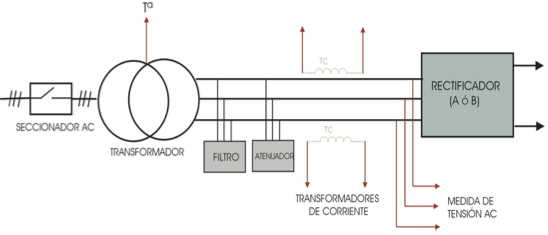

(*fuente: proyecto fin de carrera Armandino Fombella*)

### Puentes del rectificador
Esquema del rectificador A, de 12 pulsos, que produce un rizado de 600 Hz. El rectificador B, de 6 pulsos, tiene la mitad de tiristores y produce un rizado de peor calidad, a 300 Hz. El rectificador B es el que entra en fase de regeneración.

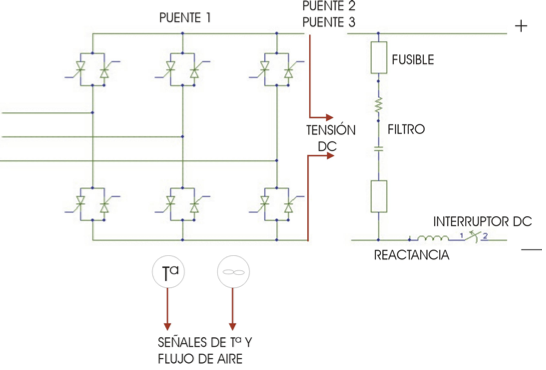

(*fuente: proyecto fin de carrera Armandino Fombella*)


## Carga de los datos
Cargamos y preparamos datos etiquetados de 40 segundos de operación del proceso, muestreados a 5000 Hz. Las etiquetas contienen información del modo de operación del proceso para cada muestra.

In [3]:
# Cargamos datos del motor
import requests
import json
datos = json.loads(requests.get("http://isa.uniovi.es/~idiaz/datos/motorCC.json").text)

# Extraemos los datos y metadatos de la estructura importada

# array de datos
p  = array(datos['p'])

# frecuencia y periodo de muestreo
fm = float(datos['fm'])
tm = 1./fm

# tamaño de los datos
Q = p.shape[1]

# vector de tiempos
t = arange(Q)*tm

# vector de etiquetas de clase
clase = 1.0*((t>0.9)&(t<34.4)) + 2.0*((t>=34.4)&(t<34.9))

etiqClases = [u'vacío',u'dando par',u'regeneración']

# nombres de las variables
nombres_variables = [
    u'corriente de inducido, $I_i$',
    u'tensión de inducido, $V$',
    u'Corriente de excitación, $I_f$',
    u'velocidad de giro en rpm, $w$']


## Trazado de las variables del motor

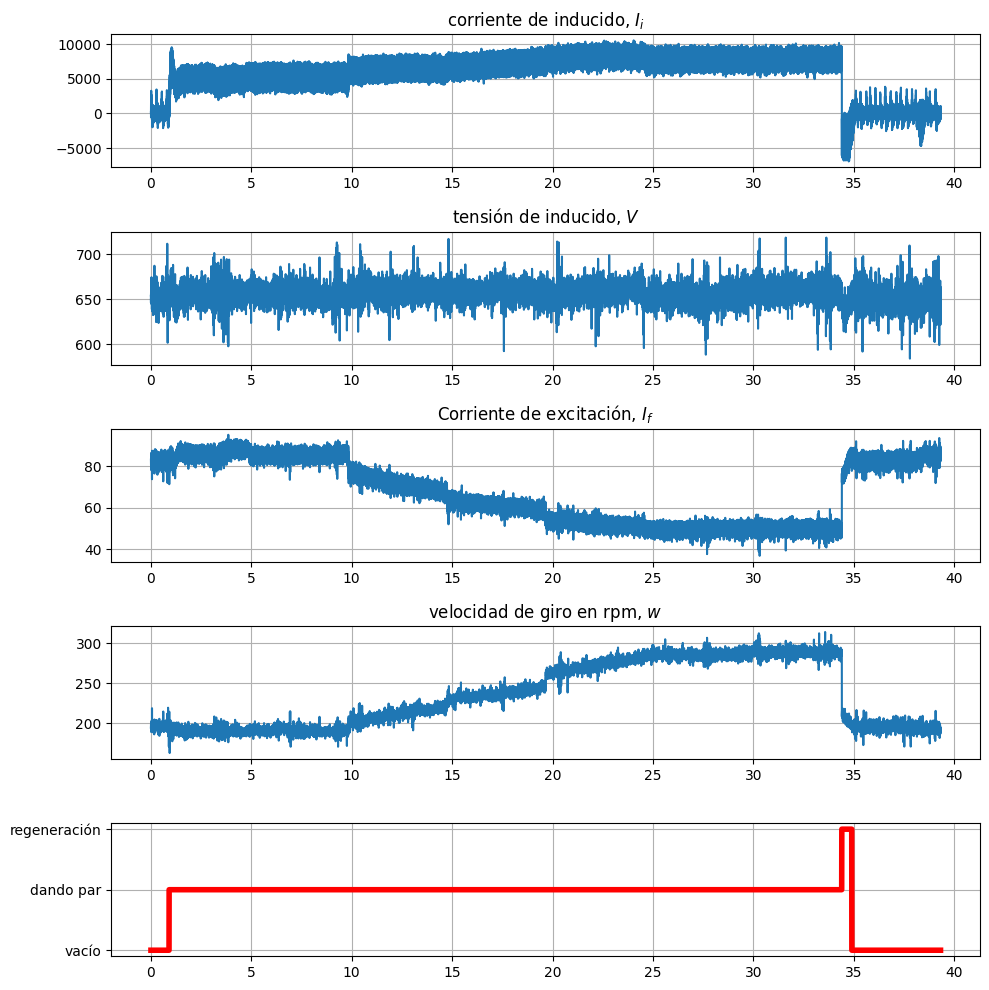

In [4]:
figure(figsize=(10,10))
for i in range(4):
    subplot(5,1,i+1)
    plot(t,p[i,:])
    grid('on')
    title(nombres_variables[i])

# dibujamos la clase a la que pertenecen
subplot(5,1,5)
plot(t,clase,'r',linewidth=4)
yticks([0,1,2],etiqClases)
grid('on')
tight_layout()

### Mostramos el detalle de dos tramos en los que cambia de estado

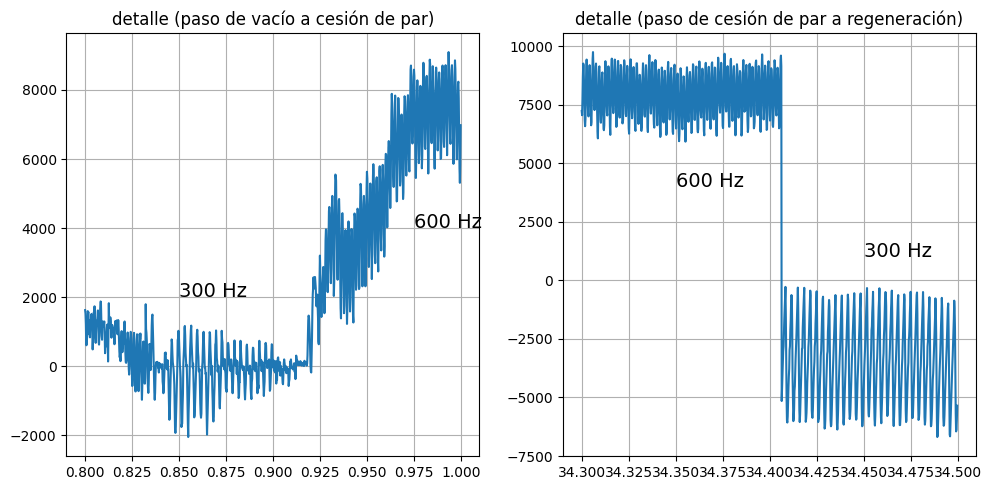

In [5]:
figure(figsize=(10,5))

subplot(1,2,1)
idx = argwhere((t>0.8) & (t<1.0))
plot(t[idx],p[0,idx])
grid('on')
axis('tight')
title(u'detalle (paso de vacío a cesión de par)')
text(0.850,2000,'300 Hz',fontsize=14)
text(0.975,4000,'600 Hz',fontsize=14)

subplot(1,2,2)
idx = argwhere((t>34.3) & (t<34.5))
plot(t[idx],p[0,idx])
grid('on')
title(u'detalle (paso de cesión de par a regeneración)')
axis('tight')
text(34.35,4000,'600 Hz',fontsize=14)
text(34.45,1000,'300 Hz',fontsize=14)

tight_layout()


* En la figura de la izquierda, podemos observar el paso de funcionamiento en vacío al estado de laminación (cesión de par), en el que la corriente de inducido aumenta, y el patrón de corriente cambia al funcionar en el primer cuadrante y utilizar una rectificación de 12 pulsos. Durante el estado de laminación, la corriente tiene un armónico de 600 Hz.
* En la figura de la derecha, vemos el paso del estado de laminación al estado de regeneración (entrega de energía a la red). La variación el patrón de armónicos de corriente es muy evidente: pasa de 600 Hz a 300 Hz

## Sonificación de la corriente en 3 tramos

Para tener una intuición de los patrones frecuenciales en la corriente, en esta celda sonificamos la corriente en tres tramos diferentes: funcionamiento en vacío, funcionamiento laminando y funcionamiento en regeneración.

Los tres tramos se muestran a continuación, y abajo se muestran enlaces para escuchar las sonificaciones

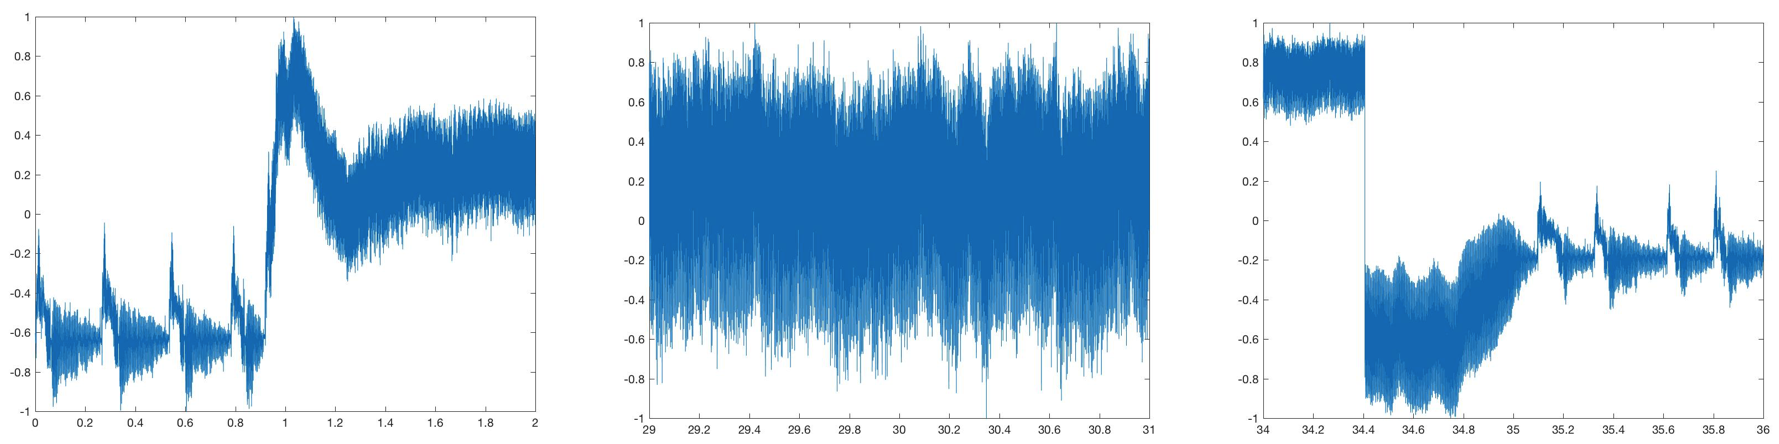

<ul>
<li><a href="http://isa.uniovi.es/~idiaz/media_google_colab/ejemplo_conv1d_datosmotorlaminacion/tramo1.mp3">sonificación tramo 1</a>
</li>

<li><a href="http://isa.uniovi.es/~idiaz/media_google_colab/ejemplo_conv1d_datosmotorlaminacion/tramo2.mp3">sonificación tramo 2</a>
</li>
<li><a href="http://isa.uniovi.es/~idiaz/media_google_colab/ejemplo_conv1d_datosmotorlaminacion/tramo3.mp3">sonificación tramo 3</a>
</li>
</ul>

In [6]:
from sklearn.model_selection import train_test_split


# tamaño de la ventana
L = 512

# salto entre ventana y ventana (esto define el solapamiento)
S = 70

# generamos un conjunto de muestras: cada muestra es una ventana de L elementos
X = []
y = []
for i in arange(0,Q-L,S):
  X.append(detrend(p[0,i:i+L]/15000.))
  y.append(clase[i])


# convertimos los datos a arrays
X = np.array(X)
y = np.array(y)

# añadimos una dimensión más a X
# X tiene que tener tres dimensiones:
#   1) índice de la muestra (número de ventanas que hayamos generado)
#   2) índice dentro de la ventana (L)
#   3) índice del canal (en este caso, sólo tratamos un canal: la I_i)
X = X[:,:,np.newaxis]

# Generamos una codificación tipo "one-hot" para las clases
y = to_categorical(np.array(y))


# particionamos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5)


## Algunas de las ventanas de $I_i$ procesadas por la red convolucional
El sistema tiene patrones frecuenciales variables, según el modo de operación. En la siguiente celda se muestran algunas de las ventanas que serán procesadas por la red  

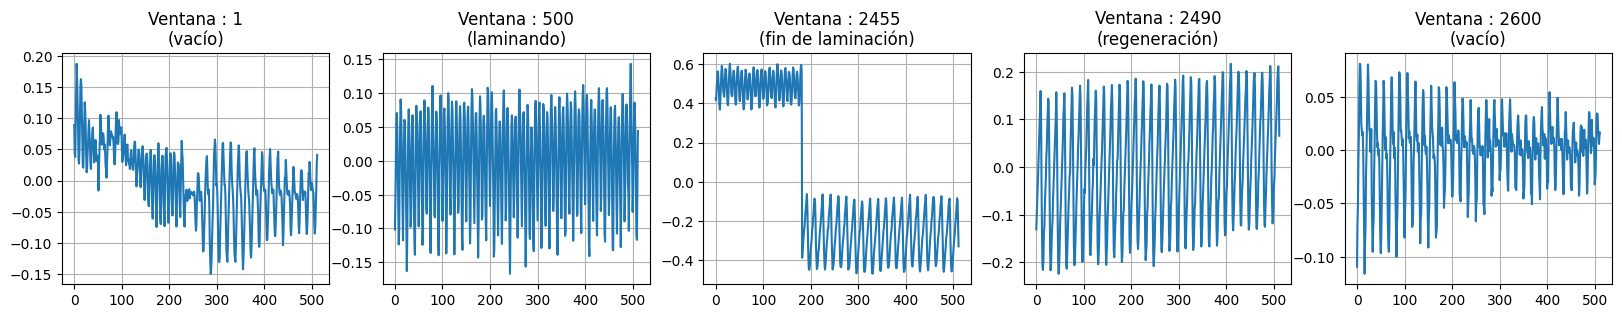

In [7]:
k = 0
figure(figsize=(20,3))
etiqVentana = ['vacío','laminando','fin de laminación','regeneración','vacío']
for i in [1,500,2455,2490,2600]:
    k = k + 1
    subplot(1,5,k)
    plot(X[i,:])
    axis('tight')
    title('Ventana : %d\n(%s)'%(i,etiqVentana[k-1]))
    grid('on')


## Operación de convolución 1D en señales
Diseñaremos una red que aplique una operación de convolución 1D sobre estas ventanas

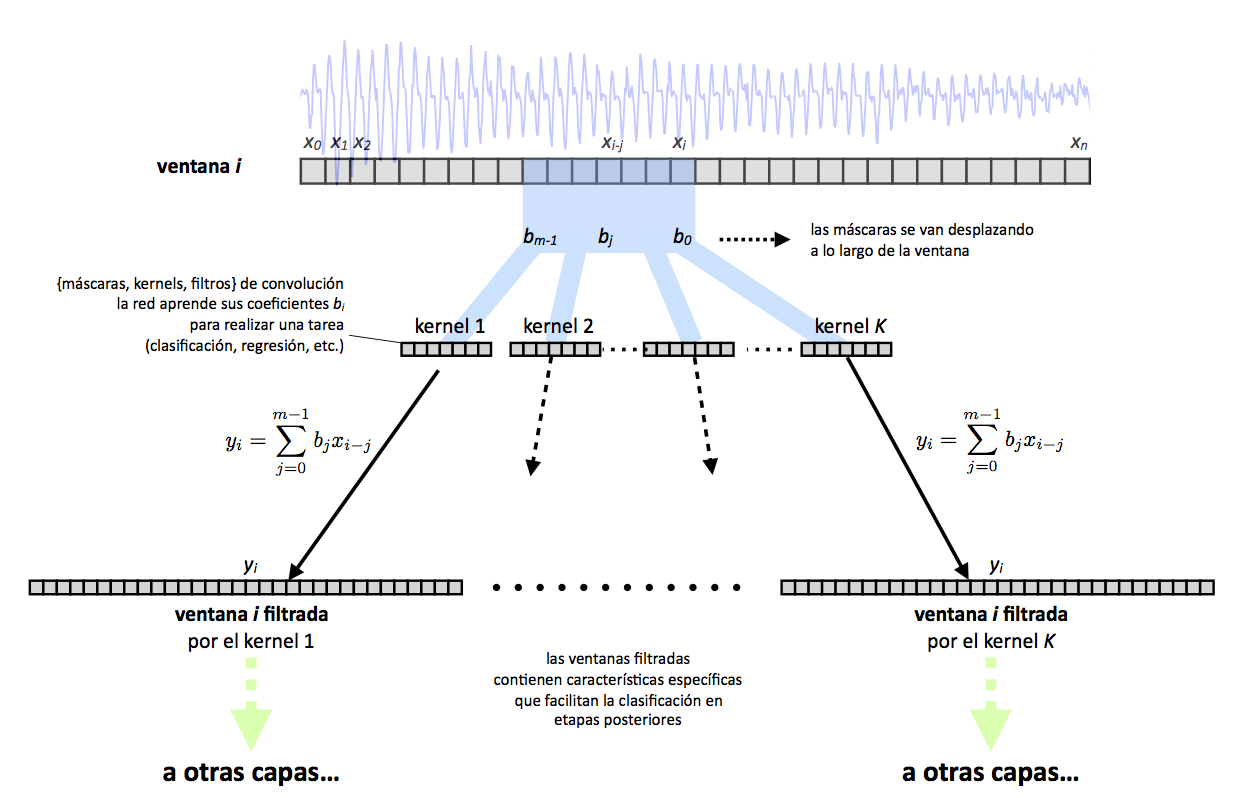


In [8]:
# Número de filtros convolucionales y tamaño
numFiltros = 8
tamFiltros = 256

# creamos el modelo
model = Sequential()

# la capa de convolución 1D utiliza 8 filtros fir de 256 coeficientes
model.add(Conv1D(       filters=numFiltros,
                        kernel_size=tamFiltros,
                        padding='same',
                        activation='relu',
                        input_shape=(L, 1)))
# ... devuelve (None,512,8) = varias instancias de 8 secuencias de 512
# dividimos en 8 partes cada secuencia, quedándonos con un valor agregado (el máximo)
model.add(MaxPooling1D(8))
# ... devuelve (None,64,8) ya que hemos dividido el tamaño de las secuencias por 8
# la capa Flatten, refunde las dimensiones 64,8 en una sola: volvemos a tener 512 activaciones
model.add(Flatten())
# ... devuelve (None,512)
model.add(Dense(32,activation='relu'))
# ... devuelve (None,32)
model.add(Dense(3,activation='softmax'))
# ... devuelve (None,3) --> hay 3 clases... cada clase es una salida


# Compilamos el modelo:
# El uso de categorical_crossentropy como función de coste da muy buen resultado
# en tareas de clasificación (distribuciones binomiales).
# Genera mayor sensibilidad de los gradientes a los errores de clasificación
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True))

# entrenamos el modelo
model.fit(X_train,y_train, epochs=200,
                batch_size=25,
                shuffle=True,
                verbose=1)

Epoch 1/200


/Users/idiazblanco/Documents/Docencia/Mecatronica/Seminario Machine Learning 2024/ejemplos-curso-ML/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3629
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1045
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0407
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 13/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 14/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 15/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072
Epoch 16/200
57/

## Visualización de los filtros convolucionales 1D ($\rightarrow$ representation learning)

En el siguiente bloque, obtenemos los coeficientes de los filtros que han sido aprendidos para realizar la tarea de clasificación. Tras el entrenamiento, los filtros se sintonizan para ser sensibles a los armónicos más relevantes en la tarea de clasificación. En este caso, los armónicos de 300Hz y 600Hz, aunque también aparecen otros que de forma menos obvia, son relevantes.

Esta facultad se denomina en la literatura **representation learning**, o "aprendizaje de representaciones". En un esquema clásico de *machine learning*, estos filtros deben ser diseñados *ad-hoc* por el analista, a partir de conocimiento de dominio del problema. En nuestro ejemplo, la red los ha aprendido de forma automática.


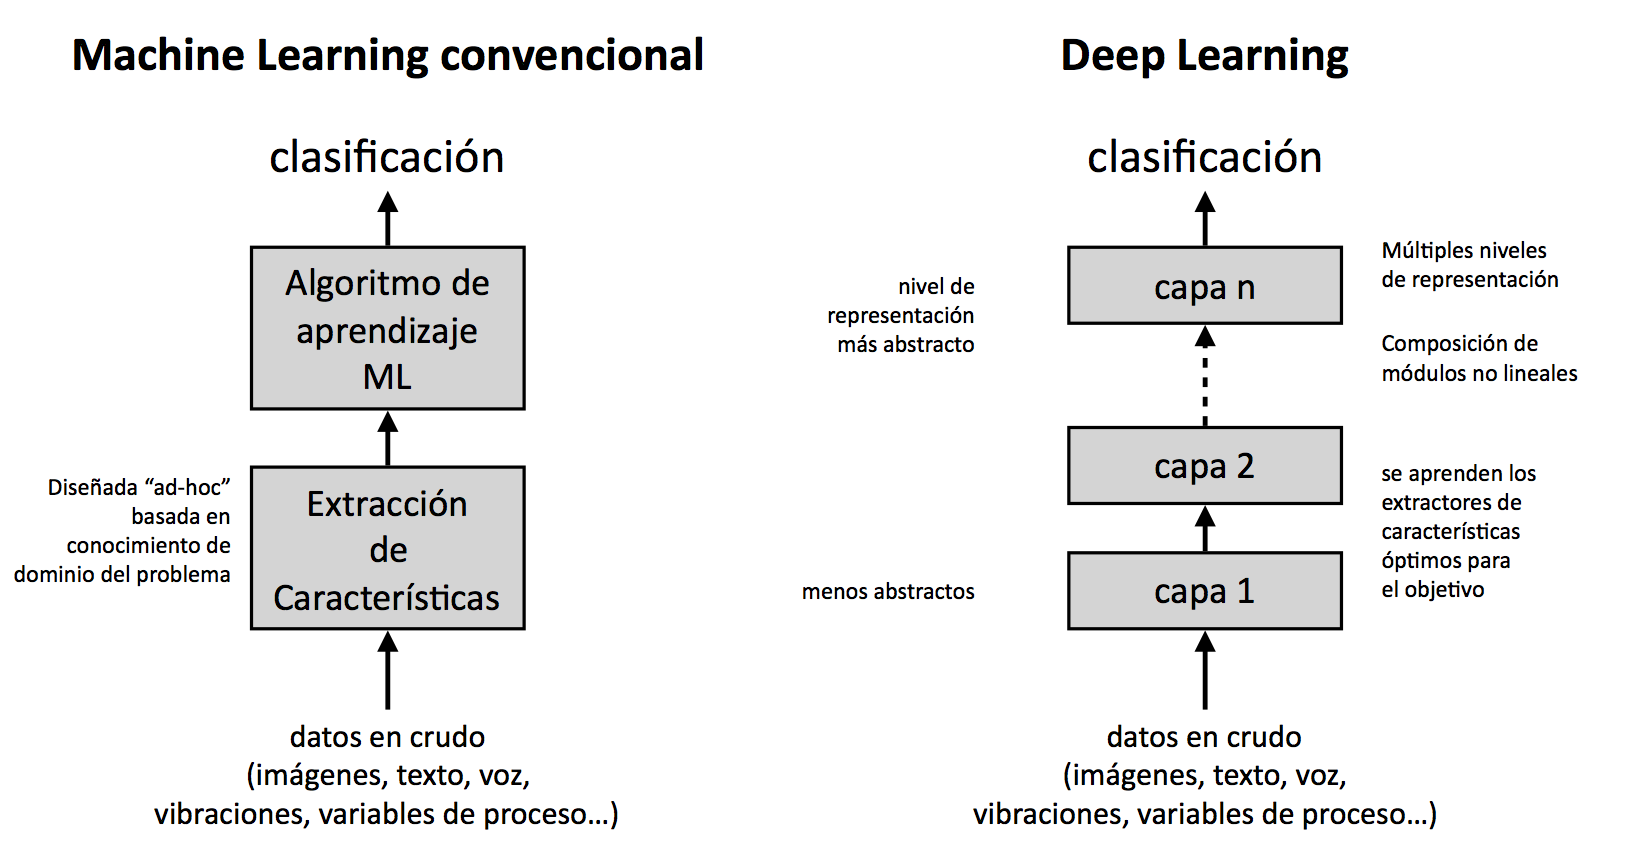

### Imagen de los coeficientes de los filtros
Extraemos los coeficientes y los representamos en una imagen

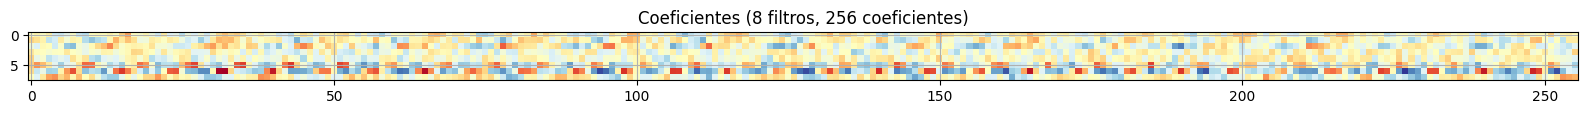

In [9]:
# extraemos los coeficientes de la capa de convolución (capa 0)
coeficientes_fir = model.layers[0].get_weights()[0].squeeze()


import matplotlib.pyplot as plt


figure(figsize=(20,10))
clf()
imshow(coeficientes_fir.T,interpolation='none',cmap = plt.cm.RdYlBu)
title('Coeficientes (8 filtros, 256 coeficientes)')
grid('off')



### Respuesta impulsional de los filtros

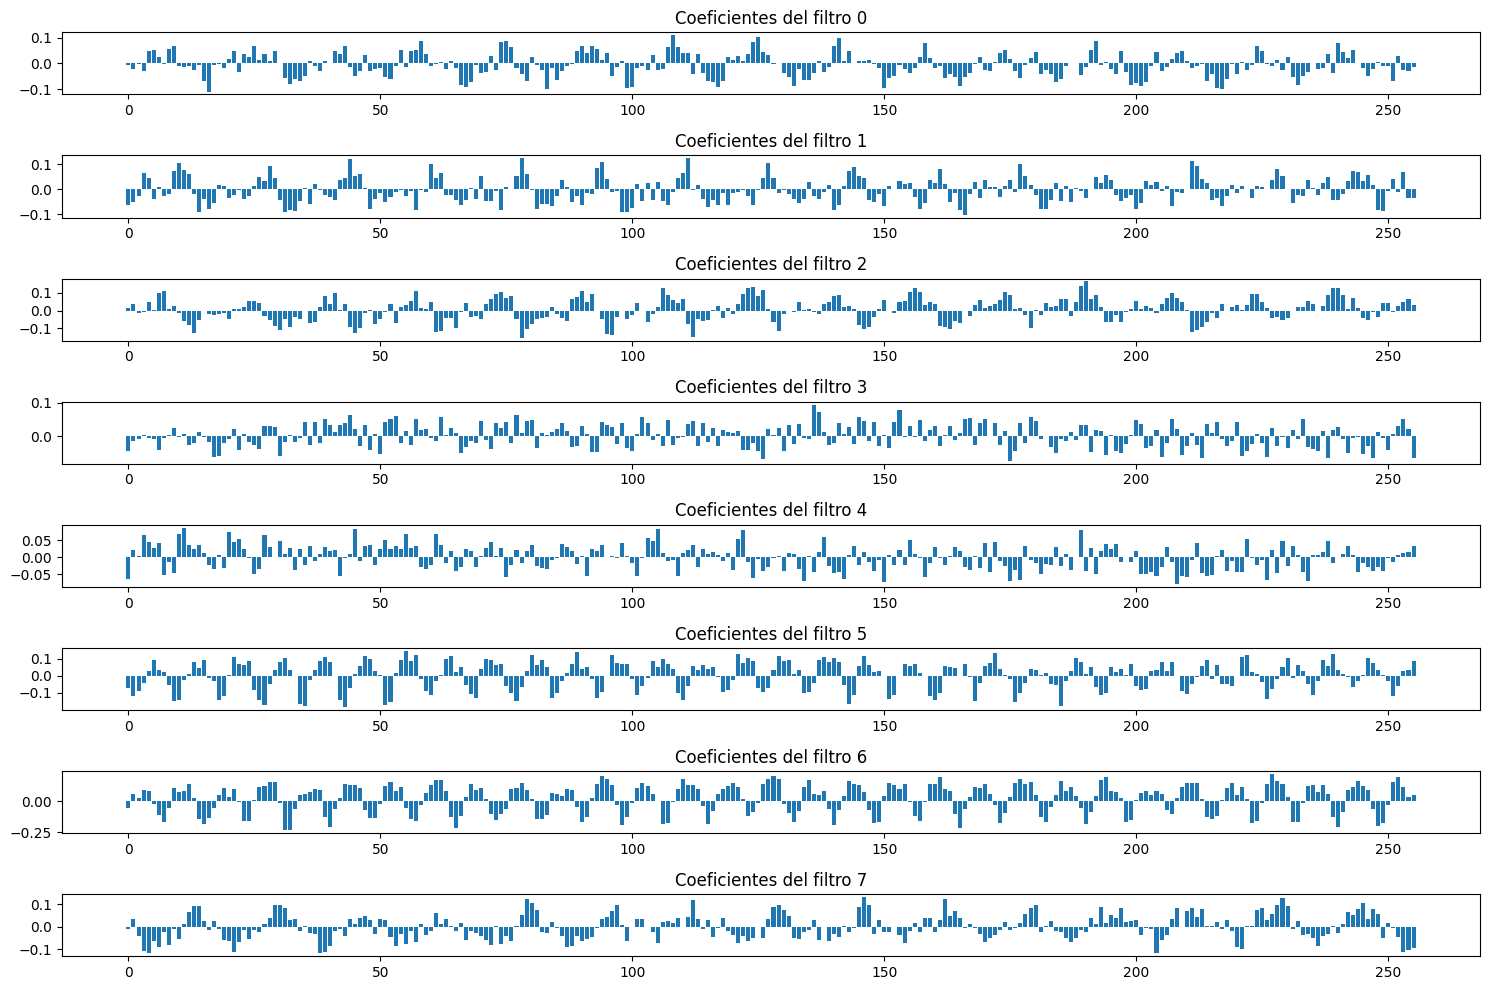

In [10]:
figure(figsize=(15,10))
for i in range(8):
  subplot(8,1,i+1)
  bar(arange(256),coeficientes_fir[:,i])
  title('Coeficientes del filtro %d'%i)

tight_layout()

### Respuesta frecuencial de los filtros
A partir de los coeficientes, podemos obtener su respuesta frecuencial mediante la *transformada rápida de Fourier* (FFT)

Observamos que los filtros revelan los armónicos relevantes para el problema de clasificación que hemos asignado a la red convolucional. Los armónicos más relevantes son los de 600Hz y 300Hz, correspondientes a los rizados de la rectificación en los modos de cesión de par y de regeneración. Aparecen también otros armónicos múltiplos (900Hz, 1200Hz) que también discriminan los estados.

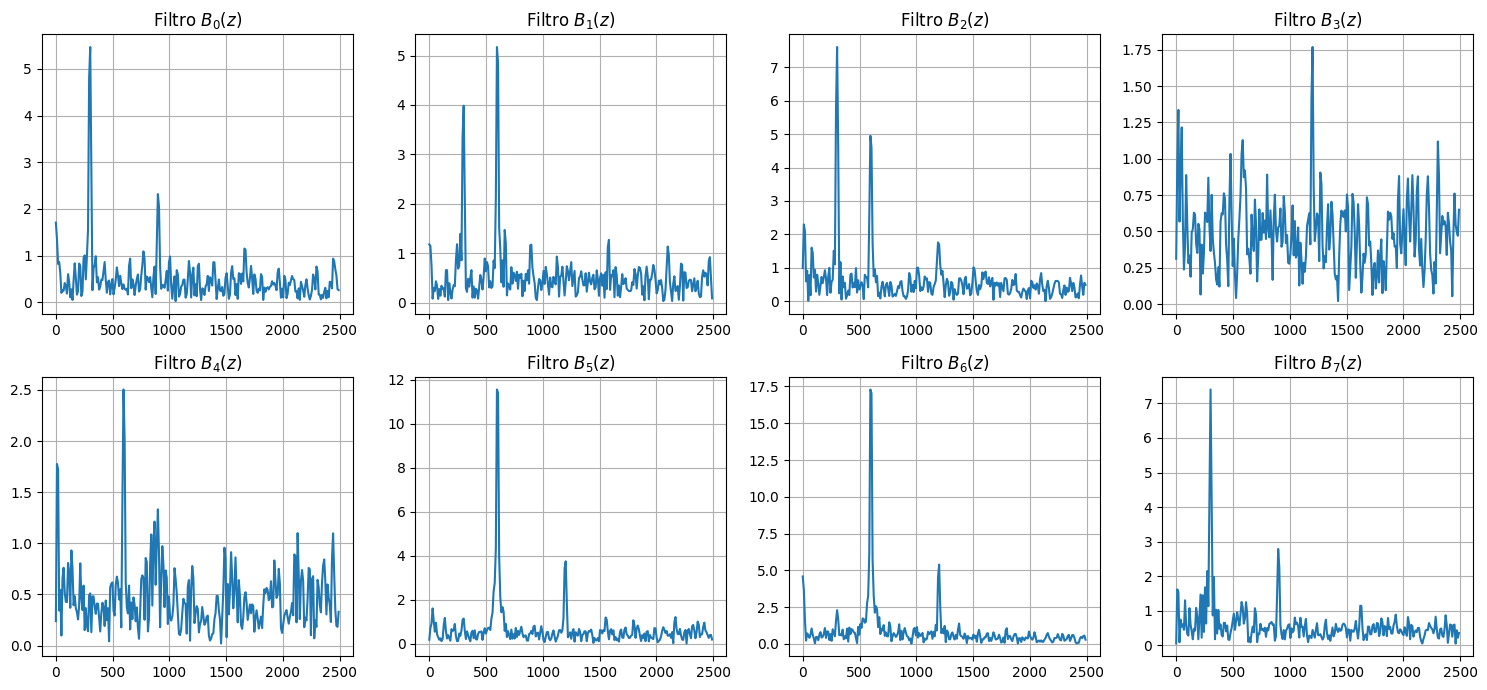

In [11]:
figure(figsize=(15,7))
clf()
N = 512
f = arange(N)*(fm/N)
for i in range(8):
    subplot(2,4,i+1)
    plot(f[:int(N/2)],abs(fft(coeficientes_fir[:,i],N))[:int(N/2)])
    title('Filtro $B_%d(z)$'%i)
    grid('on')
tight_layout()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


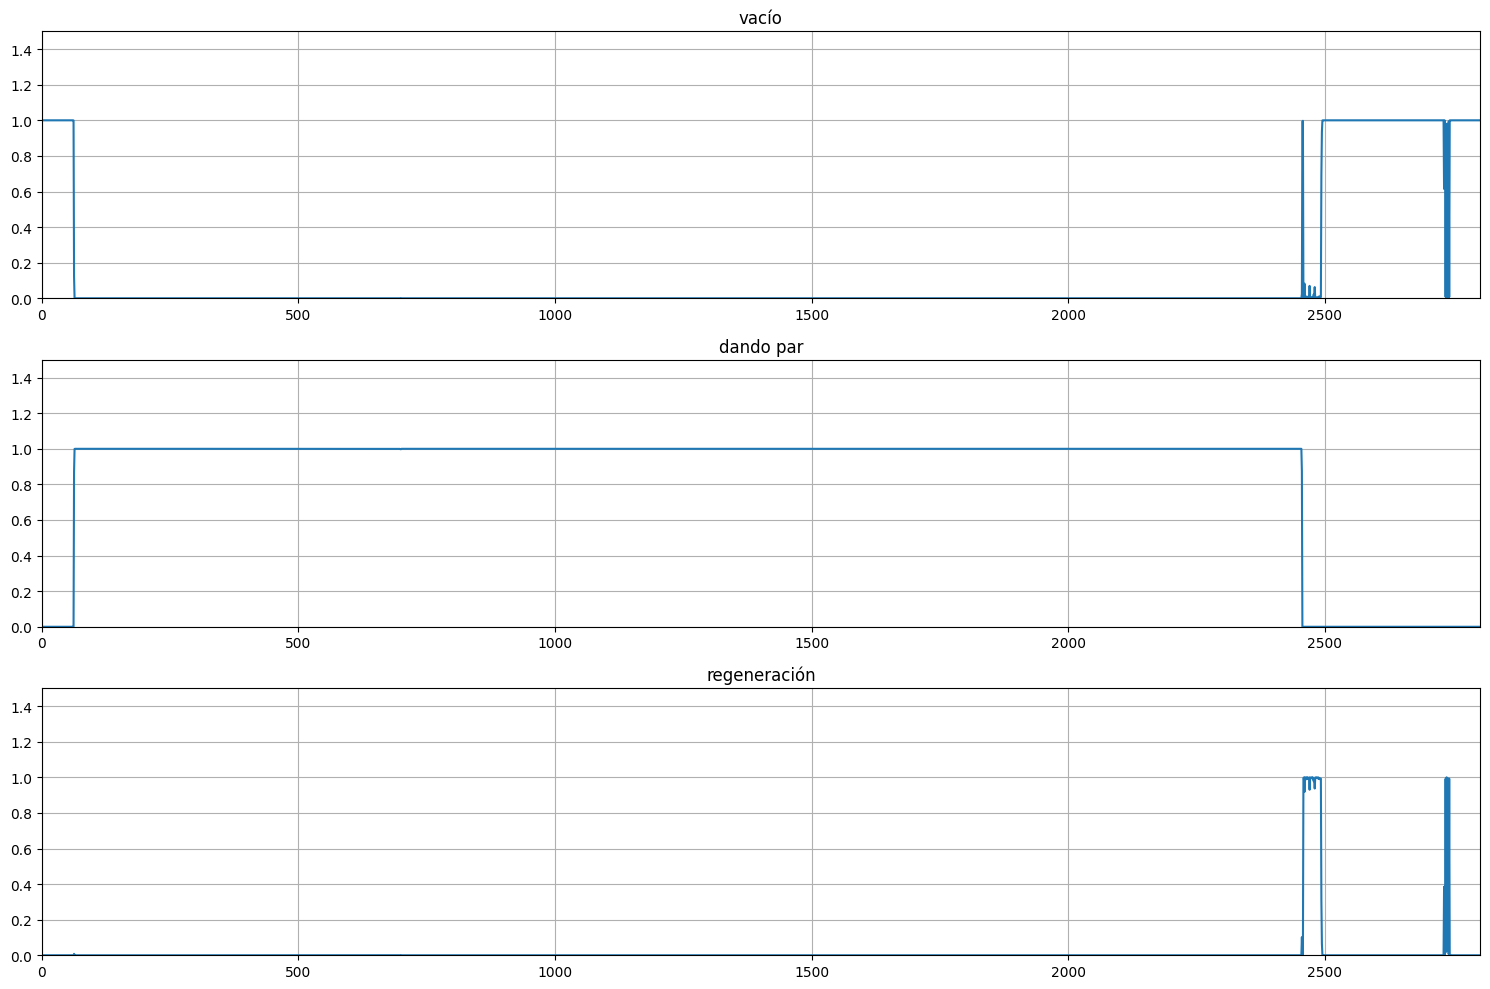

In [12]:
figure(figsize=(15,10))
clf()
yestim = model.predict(X)
numclases = yestim.shape[1]
for i in range(numclases):
    subplot(numclases,1,i+1)
    plot(yestim[:,i])
    axis([0,yestim.shape[0],0,1.5])
    title(etiqClases[i])
    grid('on')
tight_layout()

## Salida de los 8 filtros convolucionales
Se muestra a continuación la salida de los filtros convolucionales. Son 8 imágenes en las que cada columna muestra una ventana de L muestras, resultado de filtrar la ventana original (también de L muestras). Se puede ver cómo cada uno de los filtros son sensibles a los distintos estados.

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


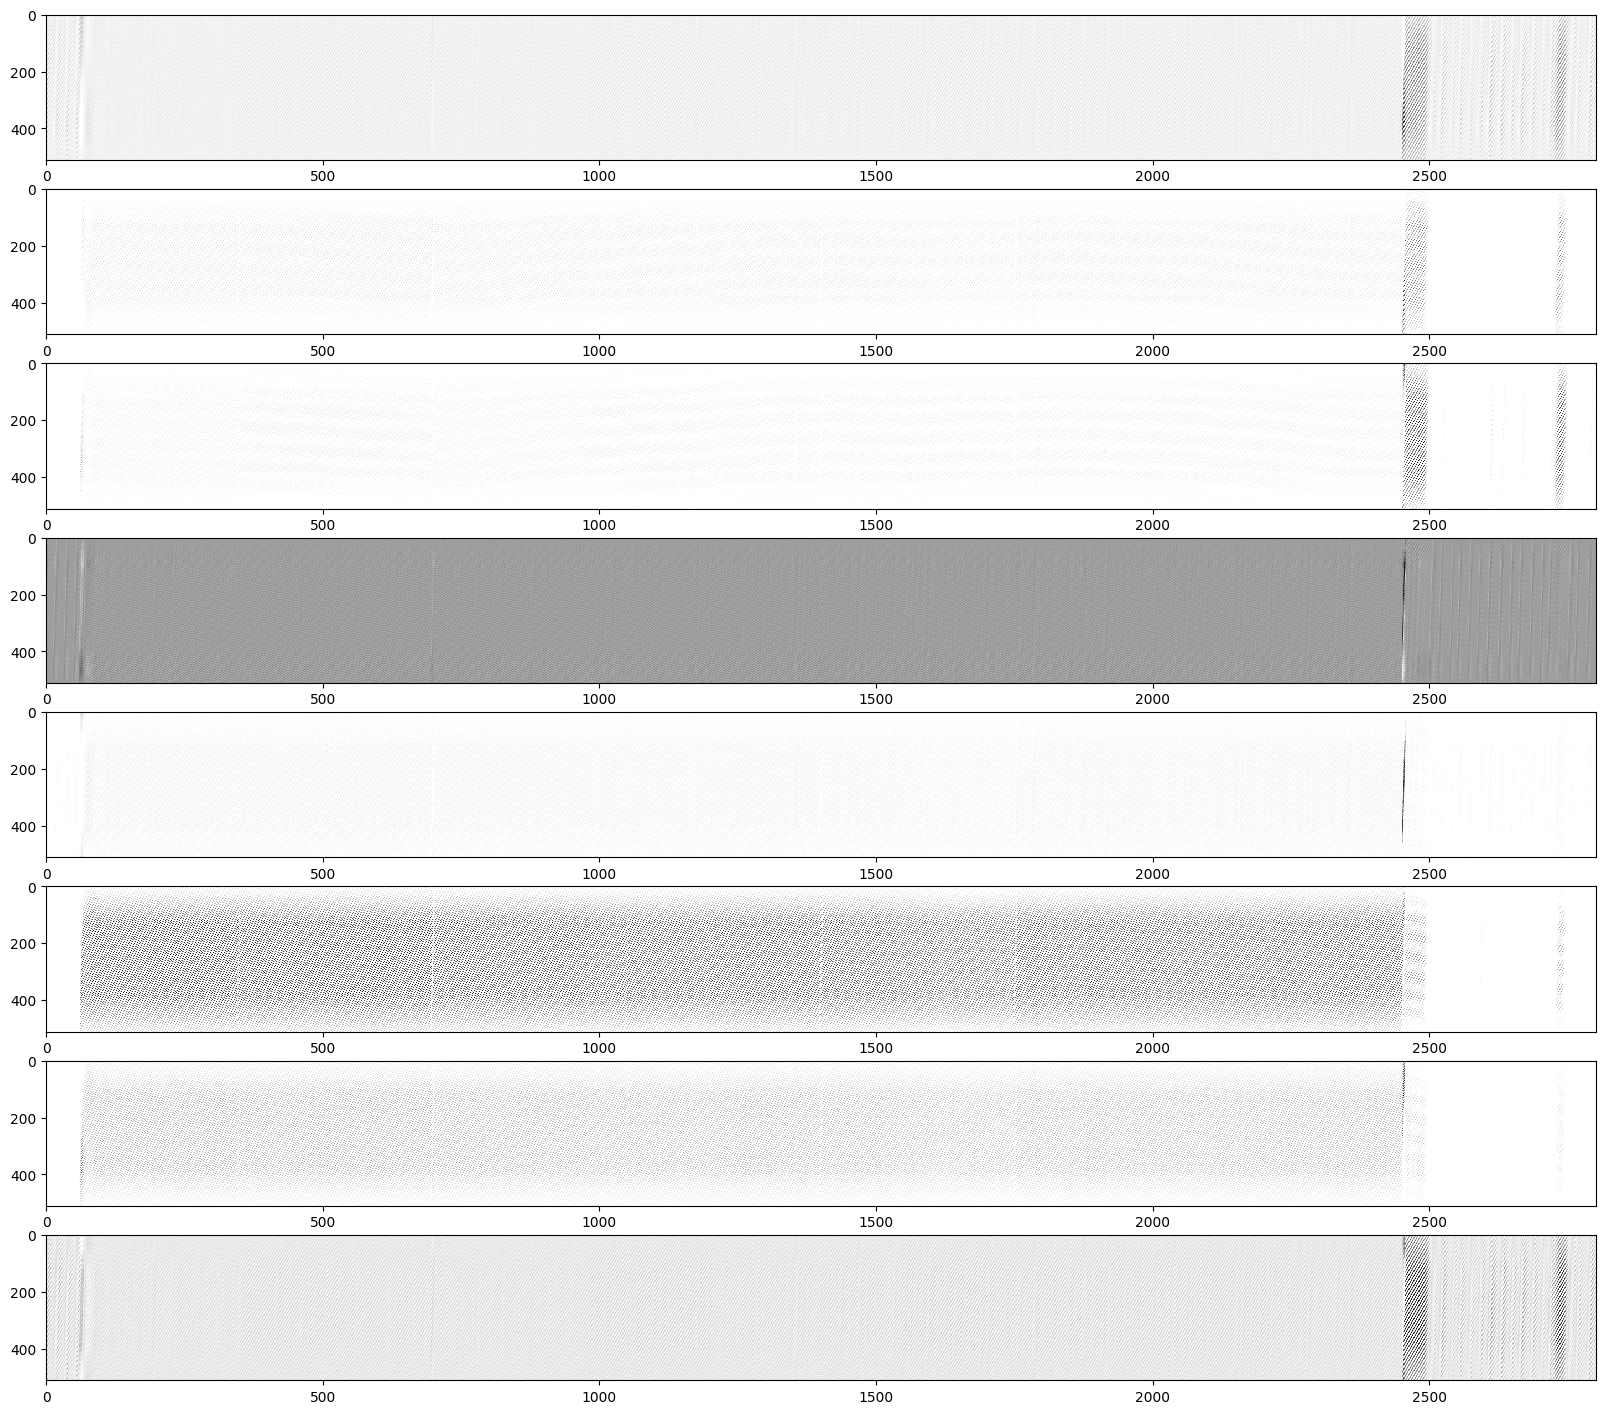

In [13]:
aux = Sequential(model.layers[0:1])
s = aux.predict(X)

figure(figsize=(20,20))
for i in range(numFiltros):
  subplot(numFiltros+1,1,i+1)
  imshow(s[:,:,i].T,interpolation='none', cmap = plt.cm.Greys)
  axis('tight')

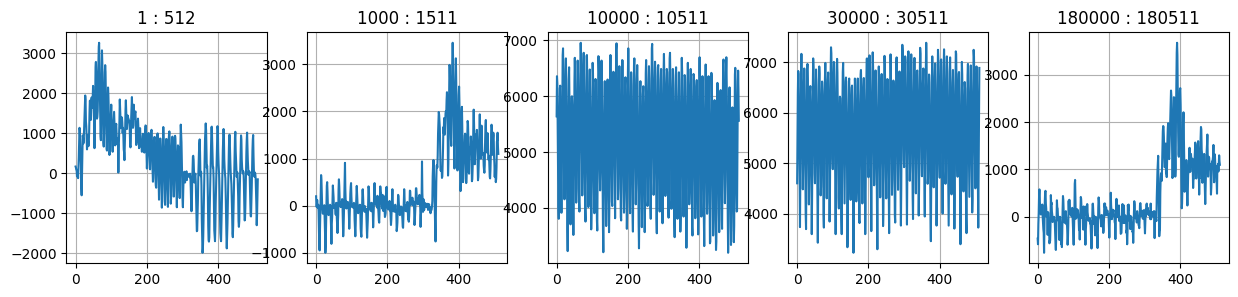

In [14]:
k = 0
figure(figsize=(15,3))
for i in [1,1000,10000,30000,180000]:
    k = k + 1
    subplot(1,5,k)
    plot(p[0,i:i+L])
    axis('tight')
    title('%d : %d'%(i,i+L-1))
    grid('on')



In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 512, 8)         │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,144 (145.10 KB)

 Trainable params: 18,571 (72.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,573 (72.55 KB)